# PROJECT 13 주식 예측에 도전해 보자

## 시계열 예측이란

### 시계열
시계열이란 시간 순서대로 발생한 테이터의 수열이라는 뜻입니다.  

시계열 데이터를 가지고 미래의 데이터를 예측하기 위해서는 다음 두 가지 전제가 필요합니다.  
> 1. 과거의 데이터에 일정한 패턴이 발견된다.  
2. 과거의 패턴은 미래에도 동일하게 반복될 것이다.  

즉, **안정적(Stationary)인 데이터에 대해서만 미래 예측이 가능하다** 는 뜻입니다.

### Stationary 한 시계열 데이터

안정적(Stationary) 시계열이란 아래 3가지 특징을 가진 시계열을 말합니다.  
(출처: http://www.dodomira.com/2016/04/21/arima_in_r/)  

1. 시간의 추이와 관계 없이 평균이 불변  
- 데이터가 모든 시점에서 일정한 평균을 가져야합니다.
![Stationary1](image/Stationary1.png)  

2. 시간의 추이와 관계 없이 분산이 불변  
- 데이터가 평균을 중심으로 퍼져있는 정도가 일정해야합니다.
![Stationary2](image/Stationary2.png)  

3. 두 시점 간의 공분산이 기준시점과 무관  
- 데이터가 어떤 특정한 변수에만 의존하지 않고 모두 일정해야합니다.
![Stationary3](image/Stationary3.png)  

## 1 시계열 데이터 준비

삼성의 주식 데이터를 활용하여 삼성의 주식을 예측하도록 하겠습니다.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/exploration/stock_prediction/data/samsung.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)    # 시계열 데이터 생성
ts = df['Close']

ts.head()

Date
2020-02-25    57900.0
2020-02-26    56500.0
2020-02-27    55900.0
2020-02-28    54200.0
2020-03-02    55000.0
Name: Close, dtype: float64

## 2 전처리

### 2.1 결측치 처리
우선 결측치 유무부터 확인하도록 하겠습니다.

In [2]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

결측치가 없으므로, 넘어가도록 하겠습니다.

### 2.2 로그 변환
stationary 한 시계열 데이터가 아니라면,  
즉 데이터에서 시계열의 수준에 비례하여 증거하거나 감소하는 변동이 보이면 로그 변환을 통해 안정적인 시계열로 바꿀 수 있습니다.  

아래의 코드를 통해 시간에 따른 주가의 평균과 표준편차를 그래프로 확인해보도록 하겠습니다.  

In [3]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

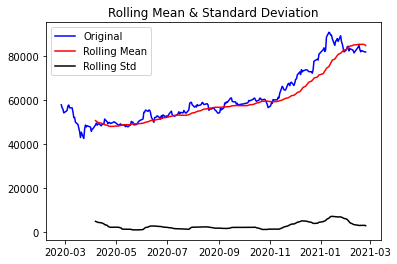

In [4]:
plot_rolling_statistics(ts, window=30)

위의 그래프를 보면 시간의 추이에 따라 평균과 분산이 증가하는 패턴을 보이는데, 이는 불안정(Non-Stationary) 한 시계열 데이터라는 의미입니다.  
로그 변환을 통해서 안정한(Stationary) 시계열 데이터로 바꾸도록 하겠습니다.

In [5]:
ts_log = np.log(ts)

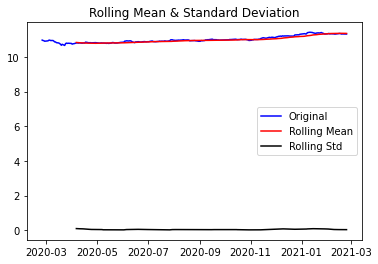

In [6]:
plot_rolling_statistics(ts_log, window=30)

위의 그래프를 통해 '시계열 데이터가 안정적이다.' 라고 결론을 내릴 수 있습니다.  
하지만 명확하게는 결론을 내릴 수 없습니다.

## 3 시계열 안정성 분석

### 3.1 Augmented Dicky-Fuller Test (ADF Test)
위에서 로그변환을 한 뒤, 정성적 그래프 분석을 통해 '시계열 데이터가 안정적이다.' 라고 결론을 내렸지만, 명확하게 결론을 내릴 수 없었습니다.  
명확하게 단정 짓기 위해서 ADF Test를 통해 정량적으로 시계열 데이터의 안정성을 테스트 해보겠습니다.

`statsmodels` 패키지에서 제공하는 `adfuller` 메소드를 이용해 주어진 시계열 데이터에 대한 `ADF Test` 를 수행할 수 있습니다.

In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [8]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.094300
p-value                          0.950003
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


ADF Test를 통해 나온 p-value 는 0.95 입니다.  
p-value 가 0.05 이상의 값을 가지므로 안정적인 시계열이라고 말할 수 없습니다.

### 3.2 시계열 분해 (Time Series Decomposition)
시계열 데이터를 Trend, Seasonality, Residual 로 분해하여 안정적인 시계열 데이터로 변환하도록 하겠습니다.

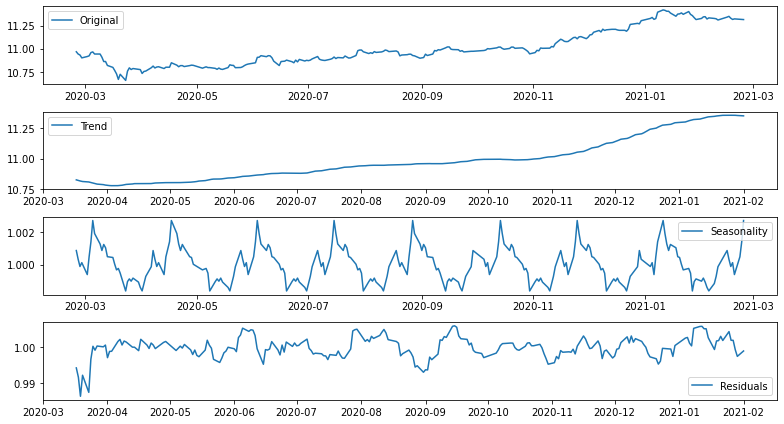

In [9]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- Trend 안정성 확인

In [10]:
trend.dropna(inplace=True)
augmented_dickey_fuller_test(trend)

Results of Dickey-Fuller Test:
Test Statistic                  -1.278762
p-value                          0.638832
#Lags Used                      13.000000
Number of Observations Used    204.000000
Critical Value (1%)             -3.462818
Critical Value (5%)             -2.875815
Critical Value (10%)            -2.574379
dtype: float64


ADF Test를 통해 나온 p-value 는 0.64 입니다.  
p-value 가 0.05 이상의 값을 가지므로 안정적인 시계열이라고 말할 수 없습니다.

- Seasonality 안정성 확인

In [11]:
seasonal.dropna(inplace=True)
augmented_dickey_fuller_test(seasonal)

Results of Dickey-Fuller Test:
Test Statistic                -1.002986e+01
p-value                        1.595615e-17
#Lags Used                     1.500000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


ADF Test를 통해 나온 p-value 는 0.000000000000000016 입니다.  
p-value 가 0.05 이하의 값을 가지므로 안정적인 시계열이라고 말할 수 있습니다.

- Residual 안정성 확인

In [12]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.096981
p-value                          0.000014
#Lags Used                       0.000000
Number of Observations Used    217.000000
Critical Value (1%)             -3.460849
Critical Value (5%)             -2.874953
Critical Value (10%)            -2.573919
dtype: float64


ADF Test를 통해 나온 p-value 는 0.000014 입니다.  
p-value 가 0.05 이하의 값을 가지므로 안정적인 시계열이라고 말할 수 있습니다.

decomposing 을 통해 얻어진 Seasonality 와 Residual은 압도적으로 낮은 p-value 를 보여줍니다.  
이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있습니다.  

## 4 ARIMA 모델

ARIMA 모델을 통해서 비정상 시계열을 다뤄보도록 하겠습니다.  
ARIMA 모델은 차분을 통해서 비정상성을 해결합니다.

ARIMA 는 AR(Autoregressive) + I(Integrated) + MA(Moving Average)가 합쳐진 모델입니다.  
> AR( Autoregressive)  
    - 일반적인 시계열에서 Residual 에 해당하는 부분을 모델링함.  
    - AR 의 시차 : p  

> I (Integrated)  
    - 일반적인 시계열에서 Seasonality 에 해당하는 부분을 모델링함.  
    - 차분 횟수 : d  

> MA (Moving Average)  
    - 일반적인 시계열에서 Trend 에 해당하는 부분을 모델링함.  
    - MA 의 시차 : q

### 4.1 p 와 q 구하기
ACF 를 통해 MA 모델의 시차 q 를 결정하고, PACF 를 통해 AR 모델의 시차 p 를 결정할 수 있습니다.

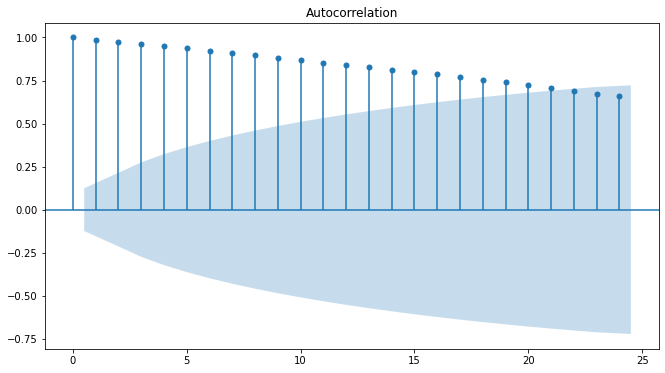

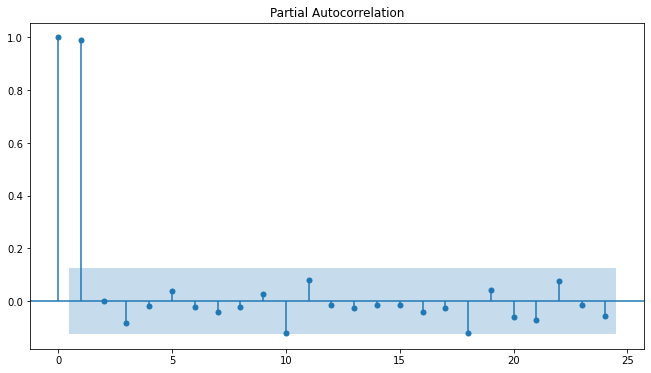

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF 는 점차적으로 감소하고 있어 AR(1) 모델에 유사한 형태를 보이고 있습니다. q 에 대해서는 적합한 값이 없어 보입니다.  

PACF 는 p 가 3 이상인 구간에서 거의 0에 가까워지고 있습니다. 그래서 p = 2 가 매우 적합한 것 같습니다.

### 4.2 d 구하기
d 를 구하기 위해서는 좀 다른 접근이 필요합니다.  
d차 차분을 구해보고 시계열이 안정된 상태인지 확인해 봐야합니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.600368e+01
p-value                        6.469449e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


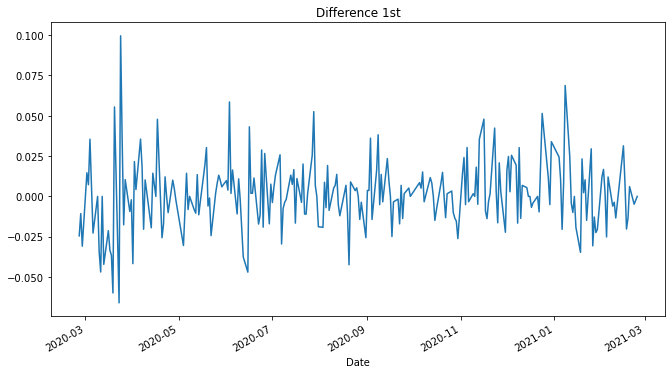

In [14]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분의 경우, p-value 값이 0.00000000000000000000000064 입니다.  
d = 1 은 매우 적합합니다.

Results of Dickey-Fuller Test:
Test Statistic                -7.545669e+00
p-value                        3.288678e-11
#Lags Used                     1.500000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


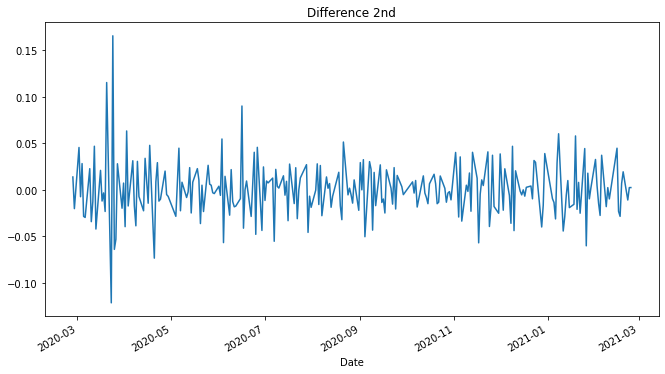

In [15]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

2차 차분의 경우, p-value 값이 0.000000000033 입니다. 1차 차분의 p-value 보다 높은값 입니다.  
그래서 d = 1 이 제일 적합합니다.

## 5 학습, 테스트 데이터셋 생성

시계열 데이터에서 학습 데이터와 테스트 데이터를 분리해보도록 하겠습니다.  
분리 비율은 학습 : 테스트 = 9 : 1 로 하겠습니다.

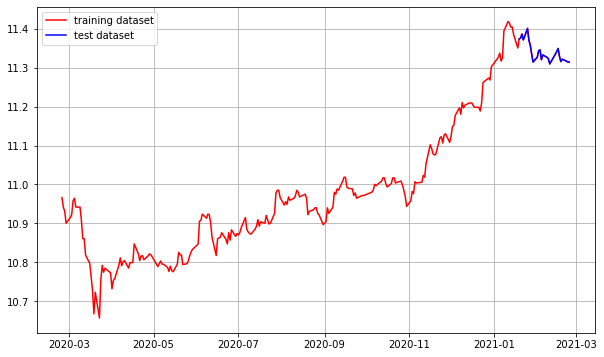

In [16]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 6 ARIMA 모델 훈련과 테스트

p = 2, d = 1, q = 0, 1, 2, ..., 10 을 파라미터로 가지는 ARIMA 모델을 고려하여 ARIMA 모델을 훈련시키도록 하겠습니다.

In [17]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(2, 1, 4))    # p, d, q
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel-dj41/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj41/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(2, 1, 4)   Log Likelihood                 538.551
Method:                       css-mle   S.D. of innovations              0.021
Date:                Fri, 26 Feb 2021   AIC                          -1061.102
Time:                        21:26:50   BIC                          -1033.881
Sample:                             1   HQIC                         -1050.112
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0018      0.001      1.894      0.058   -6.09e-05       0.004
ar.L1.D.Close     0.0213      0.032      0.663      0.508      -0.042       0.084
ar.L2.D.Close     0.9533      0.033     

/home/aiffel-dj41/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/aiffel-dj41/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
           

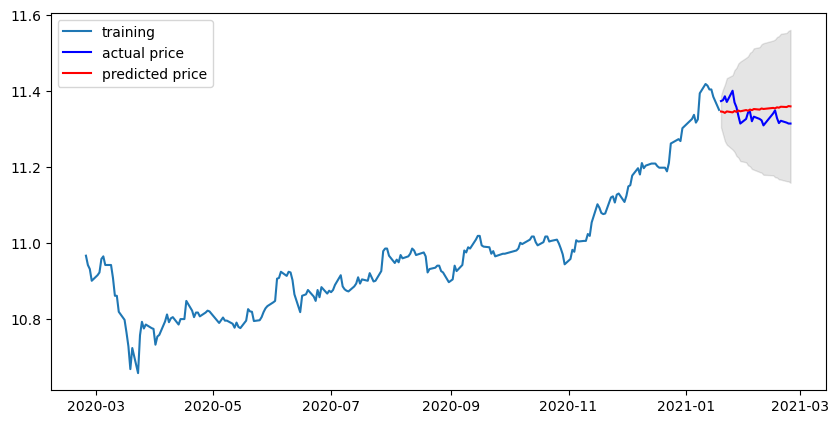

In [18]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  7044234.083749178
MAE:  2384.5572050441883
RMSE:  2654.09760252881
MAPE: 2.84%


아래 표는 ARIMA 모델에 q 의 값을 0 부터 10까지 변경하면서 학습한 MAPE를 기준으로 한 오차율입니다.  
q = 4 일 때, MAPE 를 기준으로 가장 낮은 오차율인 2.84% 보입니다.  

| q | MAPE |
|:----|:----|
| 0 | 4.09% |
| 1 | 4.09% |
| 2 | 4.32% |
| 3 | 2.97% |
| 4 | 2.84% |
| 5 | 3.07% |
| 6 | 3.39% |
| 7 | 4.71% |
| 8 | 4.71% |
| 9 | 4.55% |
| 10 | 4.45% |

## 7 다른 주식 종목 예측해 보기

### 7.1 카카오 주식

In [20]:
dataset_filepath = os.getenv('HOME') + '/aiffel/exploration/stock_prediction/data/kakao.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)    # 시계열 데이터 생성
ts = df['Close']

ts.head()

Date
2020-02-25    185500.0
2020-02-26    184000.0
2020-02-27    178500.0
2020-02-28    172000.0
2020-03-02    175000.0
Name: Close, dtype: float64

In [21]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

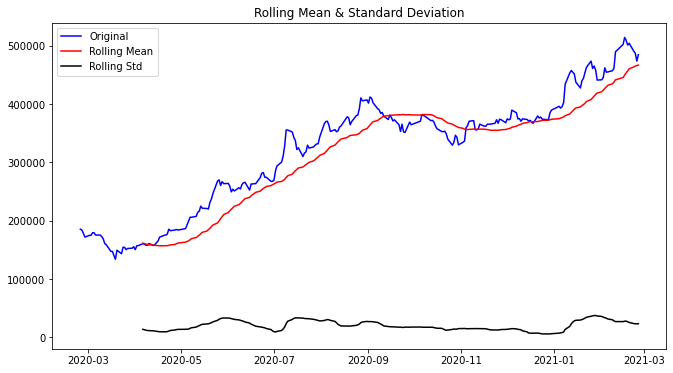

In [22]:
plot_rolling_statistics(ts, window=30)

In [23]:
ts_log = np.log(ts)

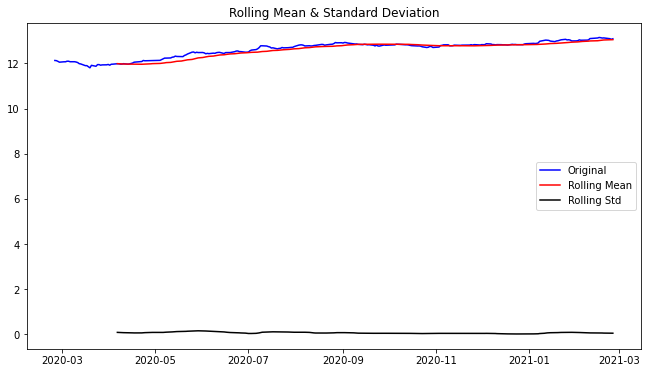

In [24]:
plot_rolling_statistics(ts_log, window=30)

In [25]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.669095
p-value                          0.854593
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


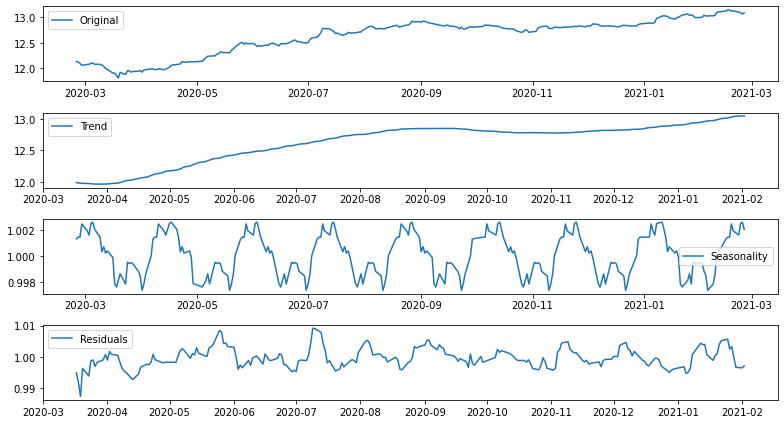

In [26]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [27]:
trend.dropna(inplace=True)
augmented_dickey_fuller_test(trend)

Results of Dickey-Fuller Test:
Test Statistic                  -3.711332
p-value                          0.003957
#Lags Used                       9.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64


In [28]:
seasonal.dropna(inplace=True)
augmented_dickey_fuller_test(seasonal)

Results of Dickey-Fuller Test:
Test Statistic                -7.648549e+00
p-value                        1.815035e-11
#Lags Used                     1.600000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


In [29]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.645077e+00
p-value                        5.290616e-09
#Lags Used                     2.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


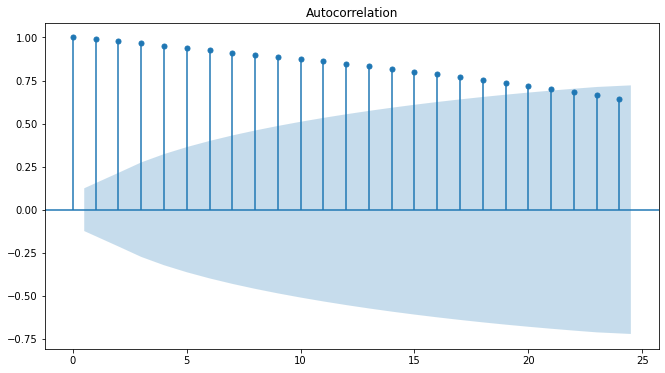

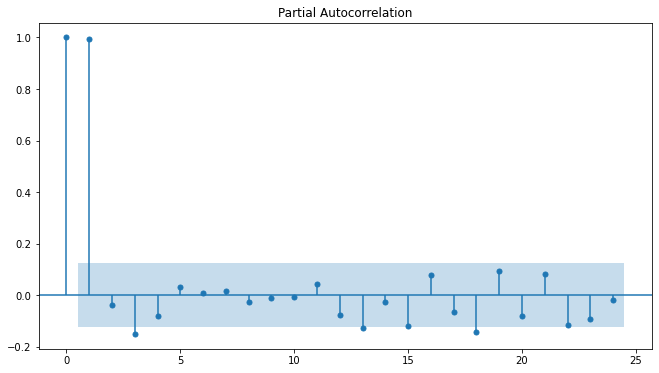

In [30]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.836670e+00
p-value                        6.089197e-12
#Lags Used                     3.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


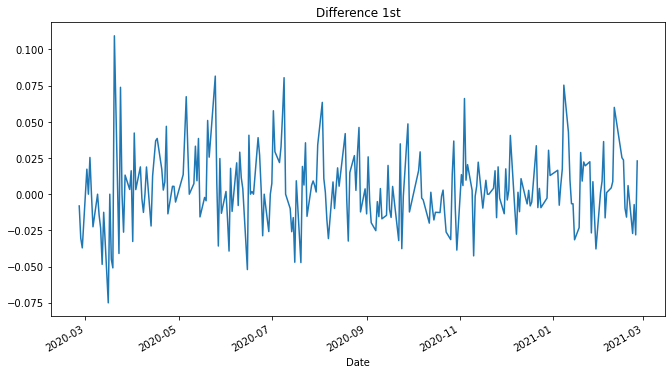

In [31]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.534901e+00
p-value                        3.499313e-11
#Lags Used                     1.500000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


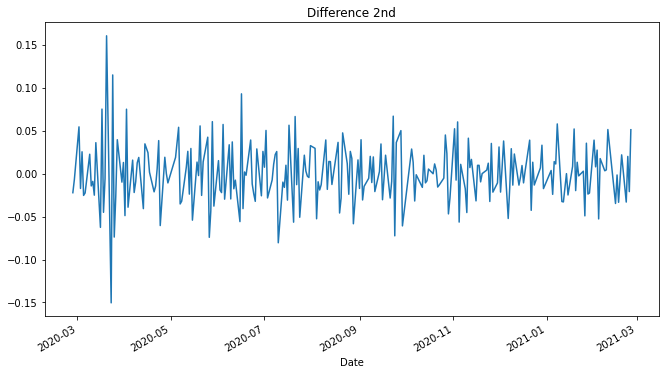

In [32]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

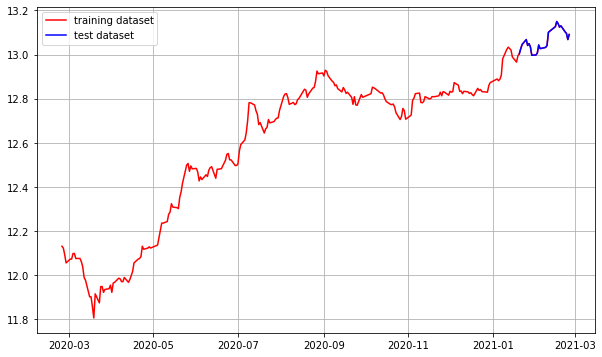

In [33]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [34]:
# Build Model
model = ARIMA(train_data, order=(2, 1, 3))    # p, d, q
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel-dj41/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj41/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  223
Model:                 ARIMA(2, 1, 3)   Log Likelihood                 495.454
Method:                       css-mle   S.D. of innovations              0.026
Date:                Fri, 26 Feb 2021   AIC                           -976.907
Time:                        21:26:53   BIC                           -953.057
Sample:                             1   HQIC                          -967.279
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.002      1.957      0.050   -6.83e-06       0.008
ar.L1.D.Close     1.0599      0.619      1.713      0.087      -0.153       2.272
ar.L2.D.Close    -0.3568      0.456     

/home/aiffel-dj41/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


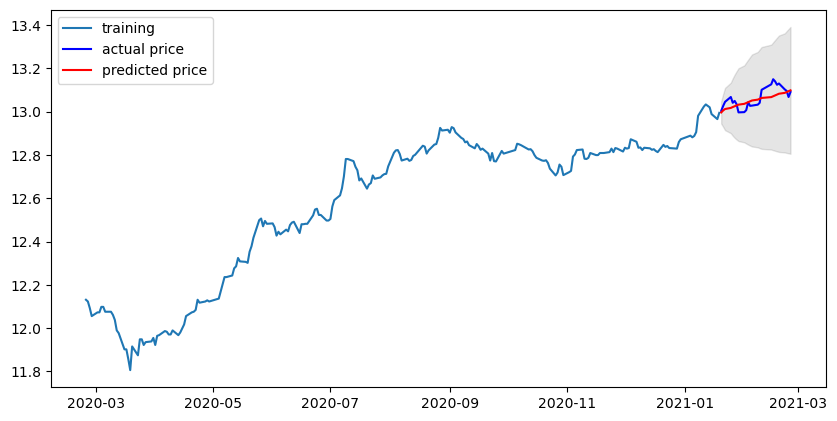

In [35]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [36]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  289443266.6290984
MAE:  14093.84286272397
RMSE:  17013.0322585099
MAPE: 2.94%


| q | MAPE |
|:----|:----|
| 0 | 3.04% |
| 1 | 3.06% |
| 2 | 3.00% |
| 3 | 2.94% |
| 4 | 2.95% |
| 5 | 3.01% |
| 6 | 3.10% |
| 7 | 3.19% |
| 8 | 3.22% |
| 9 | 2.97% |
| 10 | 3.29% |

### 7.2 에이치엠엠 주식

In [37]:
dataset_filepath = os.getenv('HOME') + '/aiffel/exploration/stock_prediction/data/HMM.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)    # 시계열 데이터 생성
ts = df['Close']

ts.head()

Date
2020-02-26    3380.0
2020-02-27    3340.0
2020-02-28    3255.0
2020-03-02    3320.0
2020-03-03    3405.0
Name: Close, dtype: float64

In [38]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

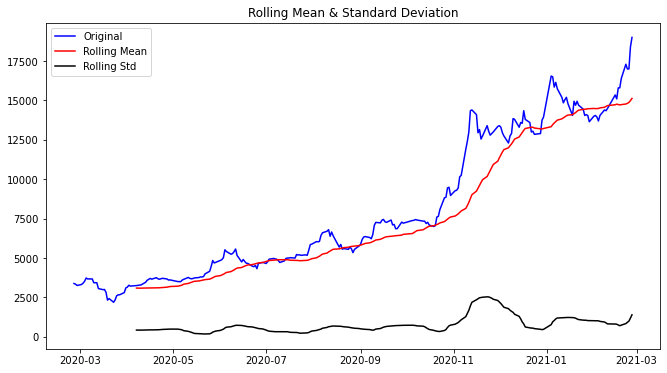

In [39]:
plot_rolling_statistics(ts, window=30)

In [40]:
ts_log = np.log(ts)

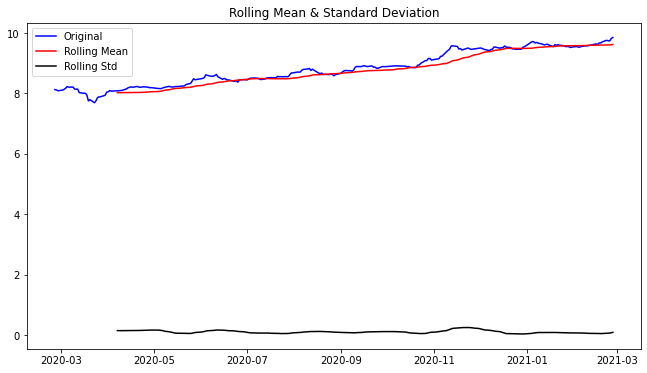

In [41]:
plot_rolling_statistics(ts_log, window=30)

In [42]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.059693
p-value                          0.953308
#Lags Used                       4.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


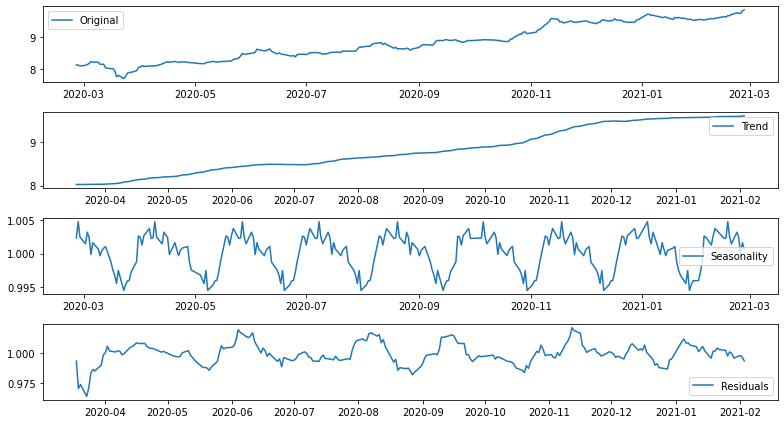

In [43]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [44]:
trend.dropna(inplace=True)
augmented_dickey_fuller_test(trend)

Results of Dickey-Fuller Test:
Test Statistic                  -0.458965
p-value                          0.899779
#Lags Used                      15.000000
Number of Observations Used    203.000000
Critical Value (1%)             -3.462980
Critical Value (5%)             -2.875885
Critical Value (10%)            -2.574416
dtype: float64


In [45]:
seasonal.dropna(inplace=True)
augmented_dickey_fuller_test(seasonal)

Results of Dickey-Fuller Test:
Test Statistic                -8.065146e+00
p-value                        1.603726e-12
#Lags Used                     1.600000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


In [46]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.135068e+00
p-value                        8.224681e-08
#Lags Used                     1.300000e+01
Number of Observations Used    2.050000e+02
Critical Value (1%)           -3.462658e+00
Critical Value (5%)           -2.875744e+00
Critical Value (10%)          -2.574341e+00
dtype: float64


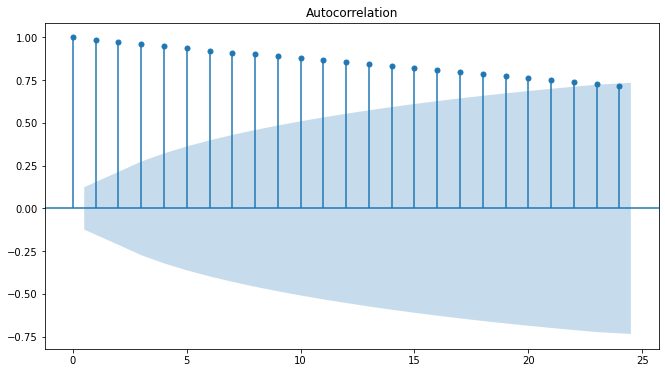

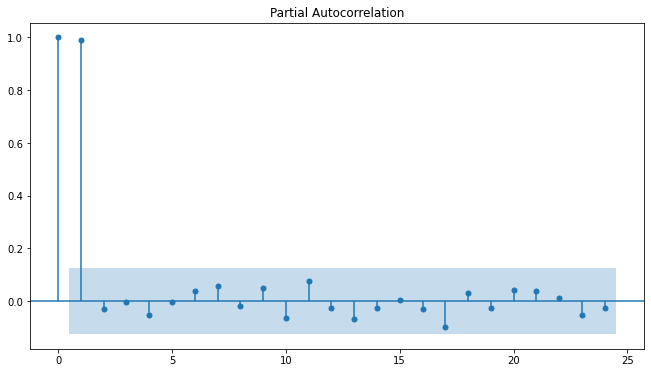

In [47]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -6.898382e+00
p-value                        1.301029e-09
#Lags Used                     3.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


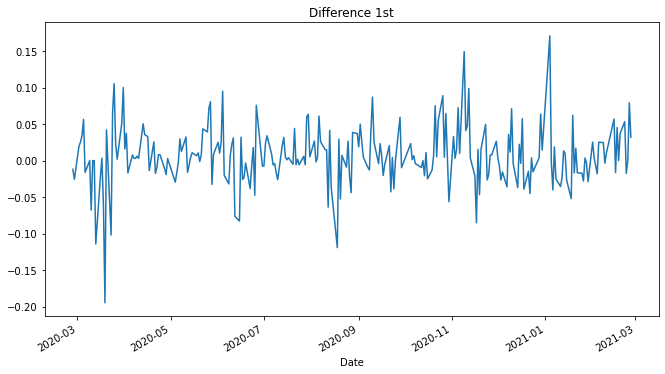

In [48]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -8.217867e+00
p-value                        6.549604e-13
#Lags Used                     1.100000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


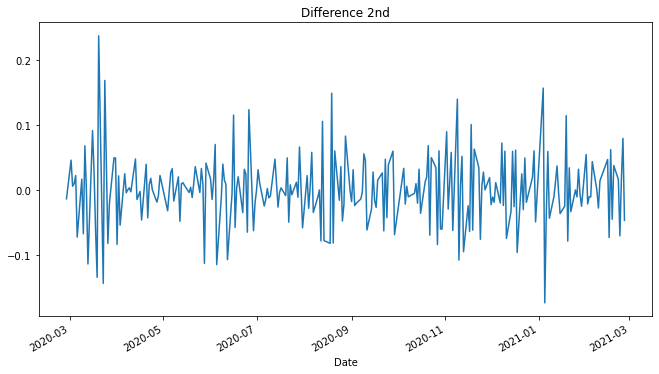

In [49]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

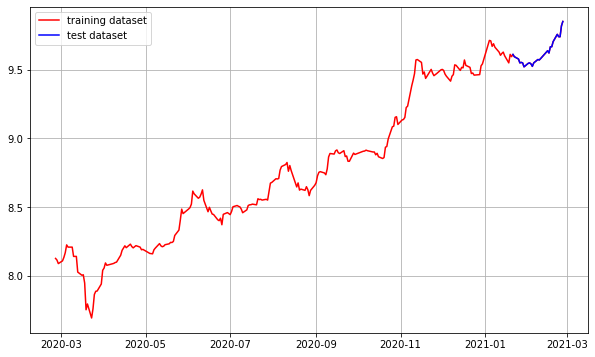

In [50]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [51]:
# Build Model
model = ARIMA(train_data, order=(2, 2, 2))    # p, d, q
fitted_m = model.fit(disp=-1, transparams=False)  
print(fitted_m.summary())

/home/aiffel-dj41/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj41/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  222
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 391.226
Method:                       css-mle   S.D. of innovations              0.037
Date:                Fri, 26 Feb 2021   AIC                           -770.452
Time:                        21:26:56   BIC                           -750.036
Sample:                             2   HQIC                          -762.209
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           3.052e-05   4.69e-05      0.651      0.515   -6.14e-05       0.000
ar.L1.D2.Close    -0.7864      0.090     -8.742      0.000      -0.963      -0.610
ar.L2.D2.Close     0.0470      0.070

/home/aiffel-dj41/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


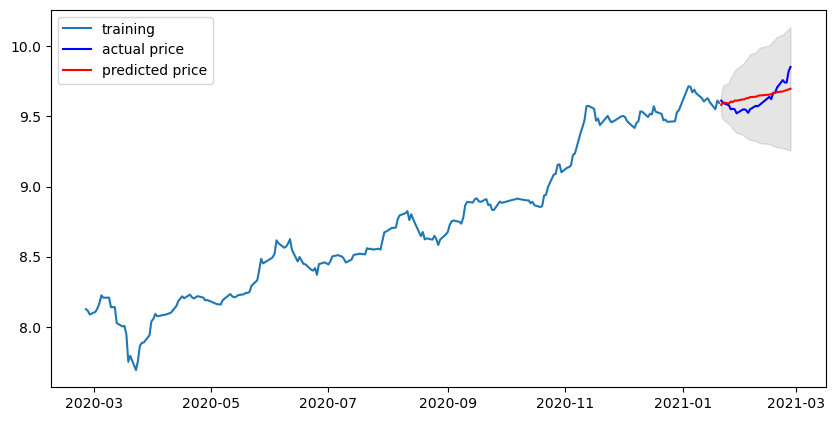

In [52]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [53]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1249285.4709649966
MAE:  924.5995060615002
RMSE:  1117.7143959728696
MAPE: 6.02%


| q | MAPE |
|:----|:----|
| 0 | 6.40% |
| 1 | 11.64% |
| 2 | 6.02% |
| 3 | 11.20% |

# [ 결과 - 루브릭 ]
**1. 시계열의 안정성이 충분히 확인되었는가?**
- 플로팅과 adfuller 메소드가 적절히 사용되었습니다. :)  

**2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?** 
- p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 제시되었습니다. :)
  
**3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?**
- 3개 이상 종목이 MAPE 10% 미만의 정확도(삼성 : 2.84%, 카카오 : 2.94%, 에이치엠엠 : 6.02%)로 예측되었습니다. :)